라이브러리 임포트 완료!
데이터 로드 완료. shape: (6362620, 11)
피처 엔지니어링 (사전 정보만 사용) 시작...
피처 엔지니어링 완료.
Train(60%) / Validation(20%) / Test(20%) 분할 시작...
Train: 3817572건 | Validation: 1272524건 | Test: 1272524건
SMOTE 샘플링 및 스케일링 시작...
SMOTE 및 스케일링 완료.
모델 학습 및 최적 임계값 탐색 시작...
[LightGBM] [Info] Number of positive: 3814383, number of negative: 3814383
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1060
[LightGBM] [Info] Number of data points in the train set: 7628766, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Validation Set에서 찾은 최적 임계값: 0.7557

[최종 현실 성능 평가 (Test Set)]
              precision    recall  f1-score   support

   Not Fraud     0.9999    0.9978    0.9989   1268270
       Fraud     0.6015    0.9805    0.7456      4254

    accura

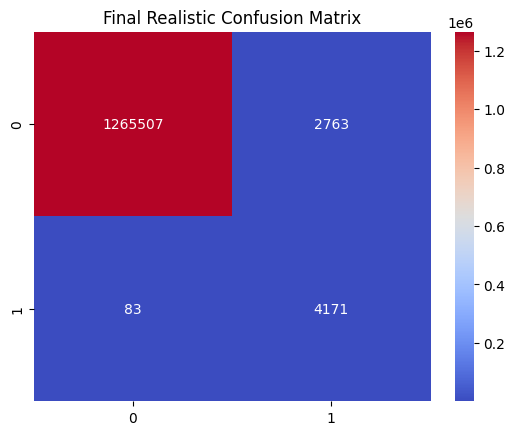


[TRANSFER, CASH_OUT 타입 한정 성능 평가]
              precision    recall  f1-score   support

   Not Fraud     0.9998    0.9951    0.9975    538437
       Fraud     0.6113    0.9805    0.7531      4254

    accuracy                         0.9950    542691
   macro avg     0.8056    0.9878    0.8753    542691
weighted avg     0.9968    0.9950    0.9955    542691


[라벨 셔플을 통한 누수 최종 검증]
원본 AUPRC: 0.4093
셔플 후 AUPRC: 0.0033
무작위 추측 수준 (사기 비율): 0.0033
>> 결과: OK. 숨겨진 누수 가능성이 낮습니다. ✅

SHAP 분석을 시작합니다...

[SHAP Feature Importance Plot (Bar)]


AssertionError: Summary plots need a matrix of shap_values, not a vector.

In [3]:
# %% [markdown]
# # 실무 FDS 모델 최종안 v3.0: 엄격한 검증 및 XAI 통합

# %%
# =================================================================
# 1. 라이브러리 임포트
# =================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    f1_score,
    average_precision_score
)
import shap

print("라이브러리 임포트 완료!")


# %%
# =================================================================
# 2. 데이터 로드
# =================================================================
try:
    paysim = pd.read_csv('../data/raw/PS_20174392719_1491204439457_log.csv')
    print("데이터 로드 완료. shape:", paysim.shape)
except FileNotFoundError:
    print("Error: 'PS_20174392719_1491204439457_log.csv' 파일을 '../data/raw/' 폴더에 넣어주세요.")
    paysim = None


# %%
# =================================================================
# 3. 피처 엔지니어링 (정보 누수 없는 피처만 생성)
# =================================================================
if paysim is not None:
    print("피처 엔지니어링 (사전 정보만 사용) 시작...")

    # 'newbalance' 관련 피처는 사후 정보이므로 모두 제외
    features_to_use = [
        'step', 'type', 'amount', 'oldbalanceOrg', 'oldbalanceDest'
    ]
    target = 'isFraud'

    X_raw = paysim[features_to_use].copy()
    y_raw = paysim[target]

    # --- 새로운 상호작용 피처 추가 (누수 없는 정보 기반) ---
    # 1. 거래 금액 대비 송금 전 잔액 비율
    X_raw['amount_to_balance_ratio'] = X_raw['amount'] / (X_raw['oldbalanceOrg'] + 1e-6)

    # 2. 송금인/수취인 잔액이 모두 0이었던 경우
    X_raw['balance_zero_both'] = ((X_raw['oldbalanceOrg'] == 0) & (X_raw['oldbalanceDest'] == 0)).astype(int)

    # 3. 거래 시간(hour) 추출 (주기성 정보)
    X_raw['hour'] = X_raw['step'] % 24

    # --- 절대 시간 정보인 'step'은 제거 ---
    X_raw = X_raw.drop(columns=['step'])

    # 'type' 피처를 원-핫 인코딩
    X = pd.get_dummies(X_raw, columns=['type'], prefix='type', drop_first=True)

    print("피처 엔지니어링 완료.")


# %%
# =================================================================
# 4. 시계열 기반 데이터 분할 (Train/Validation/Test)
# =================================================================
if 'X' in locals():
    print("Train(60%) / Validation(20%) / Test(20%) 분할 시작...")

    # 시간 순서를 유지하기 위해 원본 데이터의 인덱스를 기준으로 분할
    train_end_idx = int(X.shape[0] * 0.6)
    val_end_idx = train_end_idx + int(X.shape[0] * 0.2)

    X_train = X.iloc[:train_end_idx]
    y_train = y_raw.iloc[:train_end_idx]

    X_val = X.iloc[train_end_idx:val_end_idx]
    y_val = y_raw.iloc[train_end_idx:val_end_idx]

    X_test = X.iloc[val_end_idx:]
    y_test = y_raw.iloc[val_end_idx:]

    print(f"Train: {X_train.shape[0]}건 | Validation: {X_val.shape[0]}건 | Test: {X_test.shape[0]}건")


# %%
# =================================================================
# 5. SMOTE 샘플링 및 스케일링 (훈련 데이터에만 적용)
# =================================================================
if 'X_train' in locals():
    print("SMOTE 샘플링 및 스케일링 시작...")

    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # DataFrame으로 변환 (컬럼명 유지를 위해)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    print("SMOTE 및 스케일링 완료.")


# %%
# =================================================================
# 6. 모델 학습 및 최적 임계값 탐색
# =================================================================
if 'X_train_scaled' in locals():
    print("모델 학습 및 최적 임계값 탐색 시작...")

    model = LGBMClassifier(random_state=42, n_estimators=200)
    model.fit(X_train_scaled, y_train_resampled)

    # --- Validation Set에서 최적 임계값 탐색 및 '고정' ---
    y_val_proba = model.predict_proba(X_val_scaled)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    f1_scores = np.nan_to_num(f1_scores)
    best_threshold = thresholds[np.argmax(f1_scores)]
    
    print(f"Validation Set에서 찾은 최적 임계값: {best_threshold:.4f}")


# %%
# =================================================================
# 7. 최종 성능 평가 (Test Set)
# =================================================================
if 'model' in locals():
    print("\n[최종 현실 성능 평가 (Test Set)]")
    y_test_proba = model.predict_proba(X_test_scaled)[:, 1]
    y_pred_final = (y_test_proba >= best_threshold).astype(int)
    
    print(classification_report(y_test, y_pred_final, target_names=['Not Fraud', 'Fraud'], digits=4))

    cm = confusion_matrix(y_test, y_pred_final)
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm').set_title('Final Realistic Confusion Matrix')
    plt.show()


# %%
# =================================================================
# 8. 추가 검증 (Stress Test & Sanity Check)
# =================================================================
if 'y_pred_final' in locals():
    # --- C) 타입별 스트레스 테스트 ---
    print("\n[TRANSFER, CASH_OUT 타입 한정 성능 평가]")
    test_indices = X_test.index
    risky_types_filter = paysim.loc[test_indices, 'type'].isin(['TRANSFER', 'CASH_OUT'])
    
    if risky_types_filter.sum() > 0:
        print(classification_report(y_test[risky_types_filter], y_pred_final[risky_types_filter], target_names=['Not Fraud', 'Fraud'], digits=4))
    else:
        print("해당 타입의 테스트 데이터가 없습니다.")

    # --- D) 라벨 셔플 검증 ---
    print("\n[라벨 셔플을 통한 누수 최종 검증]")
    y_test_shuffled = y_test.sample(frac=1, random_state=42).values
    auprc_original = average_precision_score(y_test, y_test_proba)
    auprc_shuffled = average_precision_score(y_test_shuffled, y_test_proba)
    positive_ratio = y_test.mean()

    print(f"원본 AUPRC: {auprc_original:.4f}")
    print(f"셔플 후 AUPRC: {auprc_shuffled:.4f}")
    print(f"무작위 추측 수준 (사기 비율): {positive_ratio:.4f}")

    if abs(auprc_shuffled - positive_ratio) < 0.01:
        print(">> 결과: OK. 숨겨진 누수 가능성이 낮습니다. ✅")
    else:
        print(">> 결과: WARNING. 여전히 피처에 누수 가능성이 있습니다. ⚠️")


# %%
# =================================================================
# 9. XAI를 이용한 최종 모델 해석 (SHAP)
# =================================================================
if 'model' in locals():
    print("\nSHAP 분석을 시작합니다...")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_scaled)

    print("\n[SHAP Feature Importance Plot (Bar)]")
    shap.summary_plot(shap_values[1], X_test_scaled, plot_type="bar")

In [2]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

if 'lgbm_opt' in locals():
    print("SHAP 분석 및 직접 시각화를 시작합니다...")

    # 1. Explainer 및 SHAP 값 계산 (기존과 동일)
    explainer = shap.TreeExplainer(lgbm_opt)
    shap_values = explainer.shap_values(X_test_scaled)
    print("SHAP 값 계산 완료.")

    # --- 해결책: 'summary_plot' 함수를 사용하지 않고 직접 계산 및 시각화 ---
    
    # 2. '사기' 클래스에 대한 SHAP 값의 절대값 평균을 계산합니다.
    #    이것이 각 피처의 전역적인 중요도(Global Feature Importance)가 됩니다.
    mean_abs_shap = np.abs(shap_values[1]).mean(axis=0)
    
    # 3. 피처 이름과 중요도를 DataFrame으로 만듭니다.
    feature_names = X_test_scaled.columns
    shap_df = pd.DataFrame({
        'Feature': feature_names,
        'SHAP Importance': mean_abs_shap
    })
    
    # 4. 중요도 순으로 정렬합니다.
    shap_df = shap_df.sort_values('SHAP Importance', ascending=True)

    # 5. Matplotlib을 사용하여 가로 막대그래프를 직접 그립니다.
    plt.figure(figsize=(10, 8))
    plt.barh(shap_df['Feature'], shap_df['SHAP Importance'], color='royalblue')
    plt.title('Global Feature Importance (Manual SHAP Plot)', fontsize=15)
    plt.xlabel('Mean Absolute SHAP Value (Impact on Model Output)', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
